In [73]:
import os
import sys
import glob
from collections import defaultdict
from functools import reduce, partial
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import spatial

from mutspec_utils.annotation import mutations_summary, calculate_mutspec, lbl_id2lbl, lbl2lbl_id
from mutspec_utils.constants import possible_sbs192, possible_sbs12
# from mutspec_utils.draw import plot_mutspec192, plot_mutspec192box, plot_mutspec12

In [2]:
color_mapping12 = {
    "C>A": "deepskyblue",
    "G>T": "deepskyblue",
    "C>G": "black",
    "G>C": "black",
    "C>T": "red",
    "G>A": "red",  # salmon
    "T>A": "silver",
    "A>T": "silver",
    "T>C": "yellowgreen",
    "A>G": "yellowgreen",
    "T>G": "pink",
    "A>C": "pink",
}
sbs12_ordered = ["C>A", "G>T", "C>G", "G>C", "C>T", "G>A", "T>A", "A>T", "T>C", "A>G", "T>G", "A>C"]
colors12 = [color_mapping12[sbs] for sbs in sbs12_ordered]

In [103]:
def plot_mutspec12(mutspec: pd.DataFrame, ylabel="MutSpec", title="Full mutational spectrum", figsize=(6, 4), show=True, savepath=None):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.hlines(0, 0, len(sbs12_ordered), "k", "dashed", alpha=0.4, linewidth=3)
    ax = sns.boxplot(x="Mut", y=ylabel, data=mutspec, order=sbs12_ordered, ax=fig.gca())

    obs_sbs = mutspec.Mut.unique()
    reduced_order = [x for x in sbs12_ordered if x in obs_sbs]
    # map colors to bars
    for bar, sbs in zip(ax.patches, reduced_order):
        clr = color_mapping12[sbs]
        bar.set_color(clr)

    ax.set_title(title)
    ax.set_ylabel("")
    ax.set_xlabel("")

    if savepath is not None:
        plt.savefig(savepath)
    if show:
        plt.show()
    else:
        plt.close()
    return ax

In [118]:
ordered_sbs192_kp = ['A[C>A]A', 'A[C>A]C', 'A[C>A]G', 'A[C>A]T', 'C[C>A]A', 'C[C>A]C', 'C[C>A]G', 'C[C>A]T', 'G[C>A]A', 'G[C>A]C', 'G[C>A]G', 'G[C>A]T', 'T[C>A]A', 'T[C>A]C', 'T[C>A]G', 'T[C>A]T', 'T[G>T]T', 'G[G>T]T', 'C[G>T]T', 'A[G>T]T', 'T[G>T]G', 'G[G>T]G', 'C[G>T]G', 'A[G>T]G', 'T[G>T]C', 'G[G>T]C', 'C[G>T]C', 'A[G>T]C', 'T[G>T]A', 'G[G>T]A', 'C[G>T]A', 'A[G>T]A', 'A[C>G]A', 'A[C>G]C', 'A[C>G]G', 'A[C>G]T', 'C[C>G]A', 'C[C>G]C', 'C[C>G]G', 'C[C>G]T', 'G[C>G]A', 'G[C>G]C', 'G[C>G]G', 'G[C>G]T', 'T[C>G]A', 'T[C>G]C', 'T[C>G]G', 'T[C>G]T', 'T[G>C]T', 'G[G>C]T', 'C[G>C]T', 'A[G>C]T', 'T[G>C]G', 'G[G>C]G', 'C[G>C]G', 'A[G>C]G', 'T[G>C]C', 'G[G>C]C', 'C[G>C]C', 'A[G>C]C', 'T[G>C]A', 'G[G>C]A', 'C[G>C]A', 'A[G>C]A', 'A[C>T]A', 'A[C>T]C', 'A[C>T]G', 'A[C>T]T', 'C[C>T]A', 'C[C>T]C', 'C[C>T]G', 'C[C>T]T', 'G[C>T]A', 'G[C>T]C', 'G[C>T]G', 'G[C>T]T', 'T[C>T]A', 'T[C>T]C', 'T[C>T]G', 'T[C>T]T', 'T[G>A]T', 'G[G>A]T', 'C[G>A]T', 'A[G>A]T', 'T[G>A]G', 'G[G>A]G', 'C[G>A]G', 'A[G>A]G', 'T[G>A]C', 'G[G>A]C', 'C[G>A]C', 'A[G>A]C', 'T[G>A]A', 'G[G>A]A', 'C[G>A]A', 'A[G>A]A', 'A[T>A]A', 'A[T>A]C', 'A[T>A]G', 'A[T>A]T', 'C[T>A]A', 'C[T>A]C', 'C[T>A]G', 'C[T>A]T', 'G[T>A]A', 'G[T>A]C', 'G[T>A]G', 'G[T>A]T', 'T[T>A]A', 'T[T>A]C', 'T[T>A]G', 'T[T>A]T', 'T[A>T]T', 'G[A>T]T', 'C[A>T]T', 'A[A>T]T', 'T[A>T]G', 'G[A>T]G', 'C[A>T]G', 'A[A>T]G', 'T[A>T]C', 'G[A>T]C', 'C[A>T]C', 'A[A>T]C', 'T[A>T]A', 'G[A>T]A', 'C[A>T]A', 'A[A>T]A', 'A[T>C]A', 'A[T>C]C', 'A[T>C]G', 'A[T>C]T', 'C[T>C]A', 'C[T>C]C', 'C[T>C]G', 'C[T>C]T', 'G[T>C]A', 'G[T>C]C', 'G[T>C]G', 'G[T>C]T', 'T[T>C]A', 'T[T>C]C', 'T[T>C]G', 'T[T>C]T', 'T[A>G]T', 'G[A>G]T', 'C[A>G]T', 'A[A>G]T', 'T[A>G]G', 'G[A>G]G', 'C[A>G]G', 'A[A>G]G', 'T[A>G]C', 'G[A>G]C', 'C[A>G]C', 'A[A>G]C', 'T[A>G]A', 'G[A>G]A', 'C[A>G]A', 'A[A>G]A', 'A[T>G]A', 'A[T>G]C', 'A[T>G]G', 'A[T>G]T', 'C[T>G]A', 'C[T>G]C', 'C[T>G]G', 'C[T>G]T', 'G[T>G]A', 'G[T>G]C', 'G[T>G]G', 'G[T>G]T', 'T[T>G]A', 'T[T>G]C', 'T[T>G]G', 'T[T>G]T', 'T[A>C]T', 'G[A>C]T', 'C[A>C]T', 'A[A>C]T', 'T[A>C]G', 'G[A>C]G', 'C[A>C]G', 'A[A>C]G', 'T[A>C]C', 'G[A>C]C', 'C[A>C]C', 'A[A>C]C', 'T[A>C]A', 'G[A>C]A', 'C[A>C]A', 'A[A>C]A']


def __prepare_nice_labels(ordered_sbs192):
    _nice_order = []
    prev = None
    for sbs in ordered_sbs192:
        if prev is not None and sbs[2:5] != prev[2:5]:
            _nice_order.append("")
            _nice_order.append("")
        _nice_order.append(sbs[2] + sbs[4] + ": " + sbs[0] + sbs[2] + sbs[-1])
        prev = sbs
    return _nice_order
    

def plot_mutspec192box(
        mutspec192: pd.DataFrame, 
        ylabel="MutSpec", 
        title="Mutational spectrum", 
        figsize=(16, 8), 
        filepath=None, 
        fontsize=10,
        fontname="Times New Roman",
        show=True, 
    ):
    """
    Plot barblot of given mutational spectrum calculated from single nucleotide substitutions

    Arguments
    ---------
    mutspec192: pd.DataFrame
        table, containing 192 component mutational spectrum for one or many species, all substitutions must be presented in the table
    title: str, default = 'Mutational spectrum'
        Title on the plot
    filepath: str, default = None
        Path to output plot file. If None no images will be written
    """
    # TODO add checks of mutspec192
    ms192 = mutspec192.copy()
    ordered_sbs192 = [x for x in ordered_sbs192_kp if x in set(ms192.Mut.unique())]
    ms192["MutBase"] = ms192.Mut.str.slice(2, 5)
    ms192["Context"] = ms192.Mut.str.get(0) + ms192.Mut.str.get(2) + ms192.Mut.str.get(-1)
    ms192["long_lbl"] = ms192.Mut.str.get(2) + ms192.Mut.str.get(4) + ": " + ms192.Mut.str.get(0) + ms192.Mut.str.get(2) + ms192.Mut.str.get(-1)
    order = __prepare_nice_labels(ordered_sbs192)

    df = ms192.groupby(["MutBase", "Context"]).mean()
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.grid(axis="y", alpha=.7, linewidth=0.5)
    ax.hlines(0, 0, len(order), "k", "dashed", alpha=0.4, linewidth=3)
    sns.boxplot(
        x="long_lbl", y=ylabel, data=ms192,
        order=order, ax=fig.gca(),
    )
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("")
    # map colors to bars

    for bar, sbs in zip(ax.patches, [x for x in order if x]):
        s = sbs[0] + ">" + sbs[1]
        bar.set_color(color_mapping12[s])
        bar.set_alpha(alpha=0.9)

    plt.xticks(rotation=90, fontsize=fontsize, fontname=fontname)

    if filepath is not None:
        plt.savefig(filepath, tight_layout=True)
    if show:
        plt.show()
    else:
        plt.close()

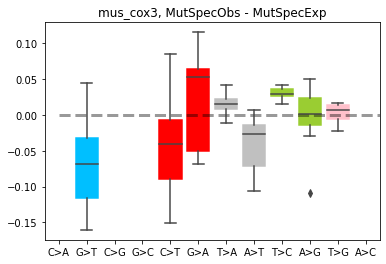

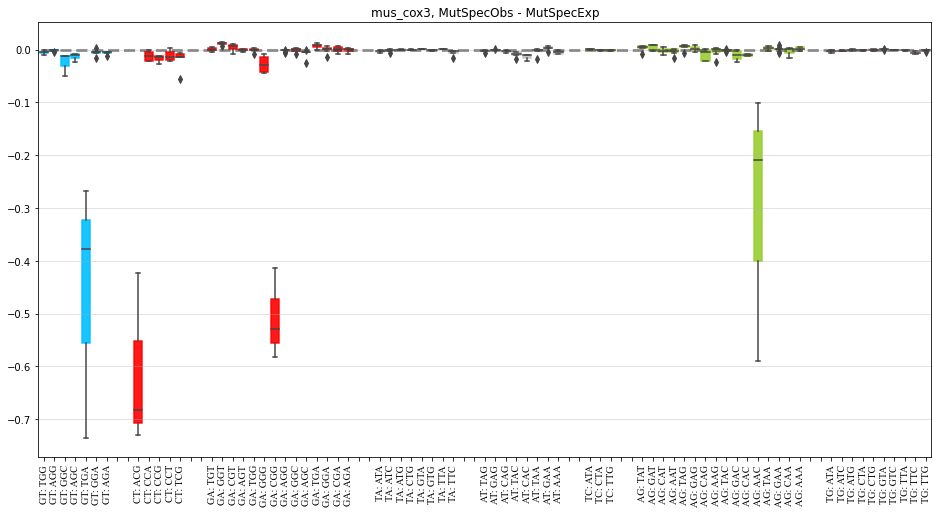

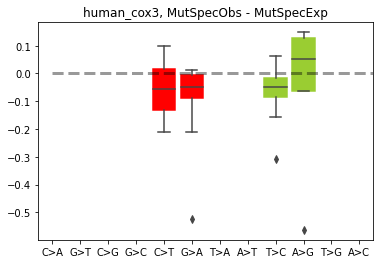

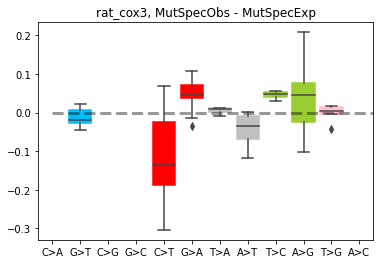

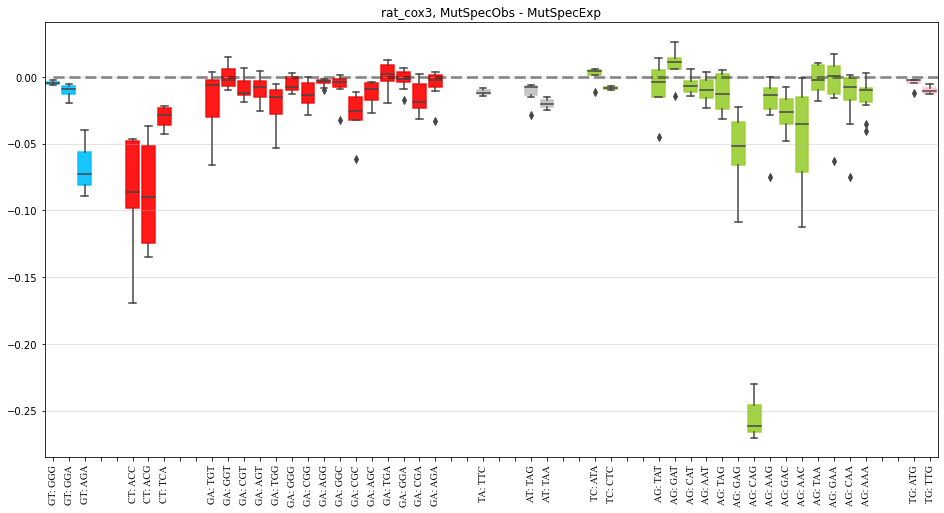

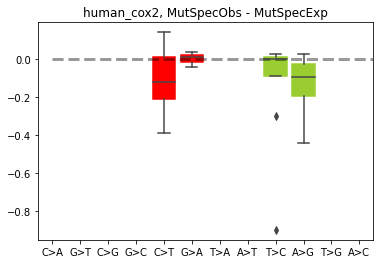

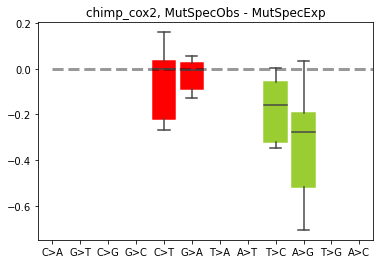

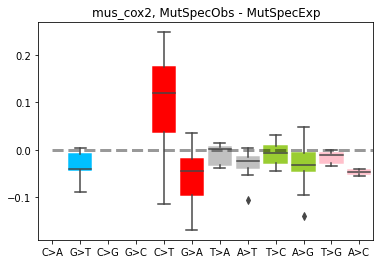

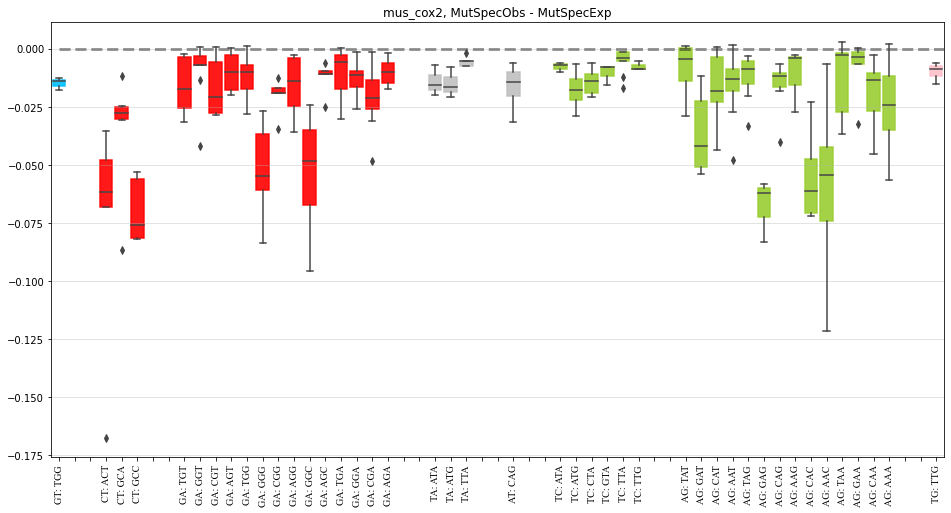

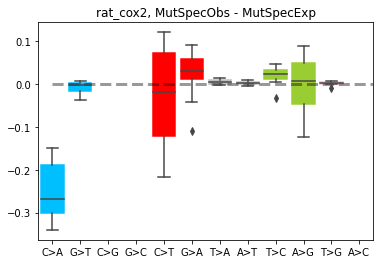

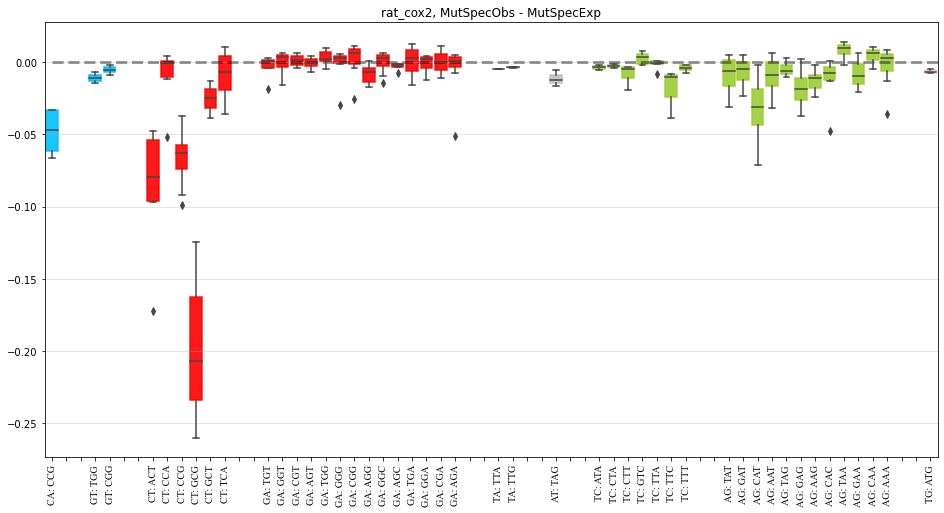

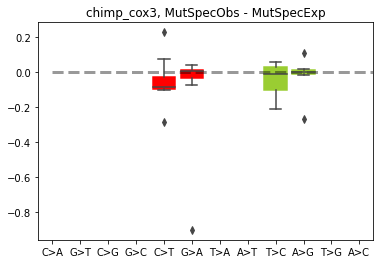

In [119]:
indir = "/home/kpotoh/Downloads/sp_ms"
for d in os.listdir(indir):
    if not os.path.isdir(os.path.join(indir, d)):
        continue
    ms12p = pd.read_csv(os.path.join(indir, d, "ms12syn_iqtree_pyvolve.tsv"), sep="\t")
    ms192p = pd.read_csv(os.path.join(indir, d, "ms192syn_iqtree_pyvolve.tsv"), sep="\t")
    ms12 = pd.read_csv(os.path.join(indir, d, "ms12syn_iqtree.tsv"), sep="\t")
    ms192 = pd.read_csv(os.path.join(indir, d, "ms192syn_iqtree.tsv"), sep="\t")

    df12 = pd.merge(ms12p[["Mut", "MutSpec"]].rename(columns={"MutSpec": "MutSpecExp"}), ms12[["Mut", "MutSpec"]].rename(columns={"MutSpec": "MutSpecObs"}), on="Mut")
    df192 = pd.merge(ms192p[["Mut", "MutSpec"]].rename(columns={"MutSpec": "MutSpecExp"}), ms192[["Mut", "MutSpec"]].rename(columns={"MutSpec": "MutSpecObs"}), on="Mut")

    df12["Diff"] = df12.MutSpecObs - df12.MutSpecExp
    df192["Diff"] = df192.MutSpecObs - df192.MutSpecExp

    df12["Nv"] = df12.Mut.map(df12.groupby("Mut").MutSpecExp.agg(lambda x: sum(x>0)).to_dict())
    df192["Nv"] = df192.Mut.map(df192.groupby("Mut").MutSpecExp.agg(lambda x: sum(x>0)).to_dict())

    n = 2
    df12f = df12[(df12.MutSpecExp > 0) & (df12.Nv > n)]
    df192f = df192[(df192.MutSpecExp > 0) & (df192.Nv > n)]
    # for sbs in set(df192.Mut.unique()).difference(df192f.Mut.unique()):
    #     df192f = df192f.append({'Mut': sbs, 'MutSpecExp': 0, 'MutSpecObs': 0, 'Diff': 0}, ignore_index=True)
    plot_mutspec12(df12f, "Diff", f"{d}, MutSpecObs - MutSpecExp", savepath=os.path.join(indir, f"diff12_{d}.png"))
    if df192f.Mut.nunique() > 10:
        plot_mutspec192box(df192f, "Diff", f"{d}, MutSpecObs - MutSpecExp", filepath=os.path.join(indir, f"diff192_{d}.png"))

    # break